In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
import torch.nn.utils.prune as prune
import copy
from util import *

In [2]:
# Generate the make_moons dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

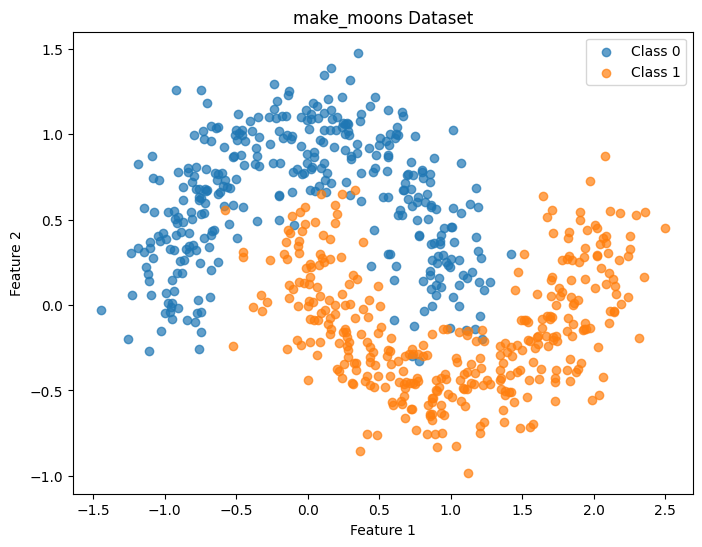

In [3]:
# Plot the make_moons dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], label='Class 0', alpha=0.7)
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], label='Class 1', alpha=0.7)
plt.title('make_moons Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [4]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
        
    def update_layers(self, new_layers):
        for i, new_layer in enumerate(new_layers):
            if hasattr(self, f'fc{i + 1}'):
                setattr(self, f'fc{i + 1}', new_layer)

In [5]:
def train_mlp_early_stopping(model, criterion, optimizer, X_train, y_train, X_val, y_val, patience=20, max_epochs=2000):
    best_val_loss = float('inf')
    no_improvement = 0

    for epoch in range(max_epochs):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_val_pred = model(torch.FloatTensor(X_val))
            val_loss = criterion(y_val_pred, torch.LongTensor(y_val)).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement = 0
            best_model = model.state_dict()
        else:
            no_improvement += 1

        if no_improvement >= patience:
            break
    # Load the best model
    model.load_state_dict(best_model)
    return epoch
    

def test_model(model, X_test, y_test):
    with torch.no_grad():
        y_test_pred = model(torch.FloatTensor(X_test)).argmax(dim=1)
        test_acc = accuracy_score(y_test, y_test_pred)
    return test_acc

In [6]:
def ece_plot(frequency, reliabilities,ece, num_bins=10):
    bin_edges = np.linspace(0.0, 1.0, num_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Plot Frequency on the primary y-axis
    ax1.bar(bin_centers, frequency, width=0.05, color='r', label='Frequency')
    ax1.set_xlabel('Confidence')
    ax1.set_ylabel('Frequency', color='r')
    ax1.tick_params('y', colors='r')
    
    # Create a secondary y-axis for Reliability
    ax2 = ax1.twinx()
    ax2.plot(bin_centers, reliabilities, linestyle='--', label='Reliability', color='b')
    ax2.set_ylabel('Reliability', color='b')
    ax2.tick_params('y', colors='b')

    plt.title(f'ECE: {ece:.4f}')
    plt.show()

In [7]:
def calculate_ece(model, X, y, title=None, num_bins=10):
    with torch.no_grad():
        y_pred = model(torch.FloatTensor(X)).softmax(dim=1).numpy()
    confidence = np.max(y_pred, axis=1)
    prediction = np.argmax(y_pred, axis=1)
    correct = prediction == y
    reliabilities = []
    frequency = []
    ece = 0.0
    bin_edges = np.linspace(0.0, 1.0, num_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    for i in range(num_bins):
        in_bin = np.logical_and(confidence > bin_edges[i], confidence <= bin_edges[i + 1])
        prop_in_bin = in_bin.astype(float).mean()
        frequency.append(np.sum(in_bin))
        if(len(correct[in_bin]) == 0):
            reliabilities.append(0)
            continue
        bin_accuracy = np.mean(correct[in_bin])
        bin_confidence = np.mean(confidence[in_bin])
        ece += np.abs(bin_accuracy - bin_confidence) * prop_in_bin
        reliabilities.append(bin_accuracy)

    return ece, frequency, reliabilities

ECE plot for pruning rate:  0.0


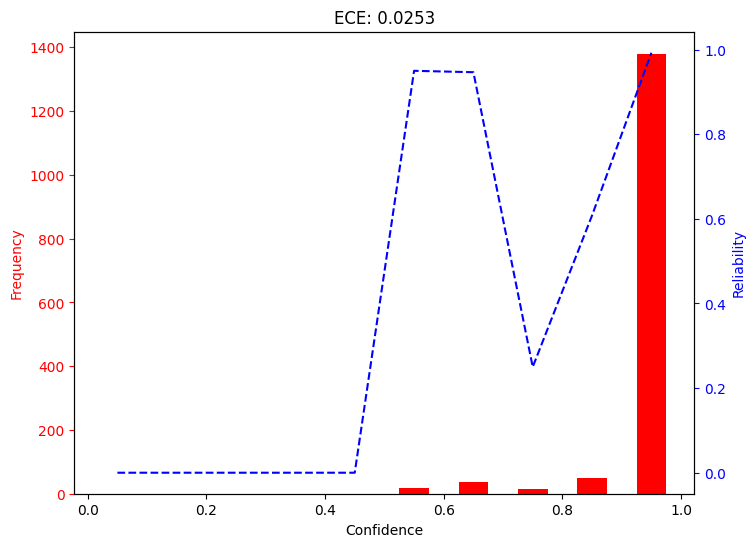

ECE plot for pruning rate:  0.1


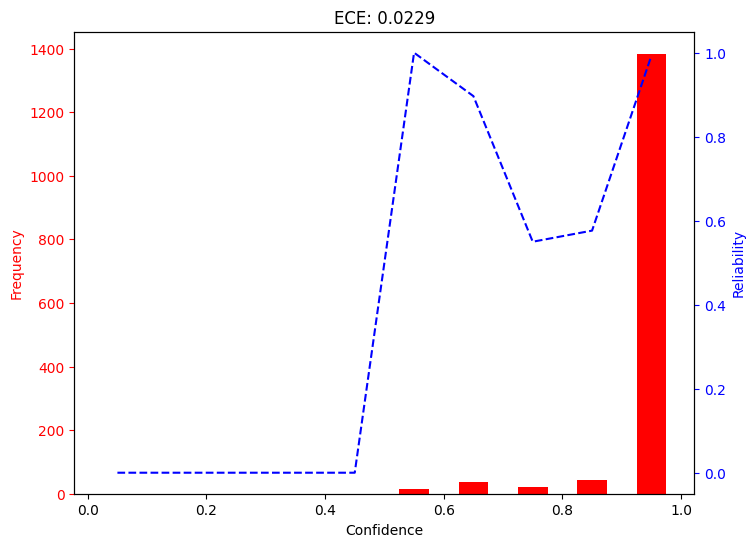

ECE plot for pruning rate:  0.2


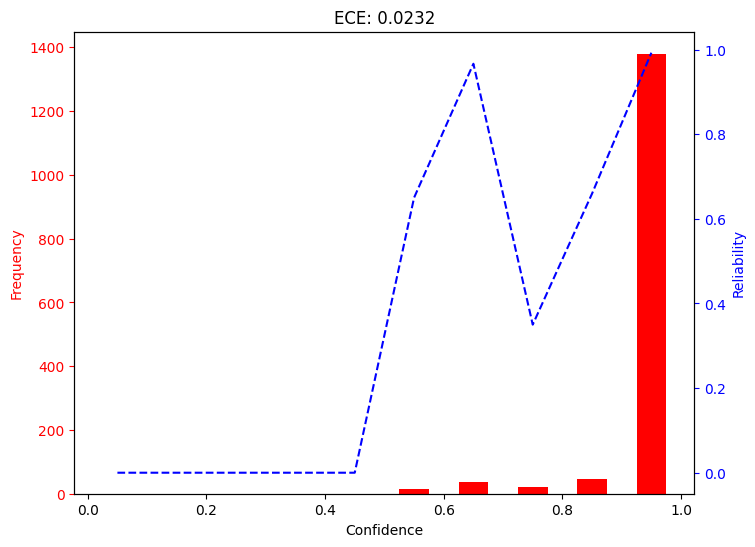

ECE plot for pruning rate:  0.30000000000000004


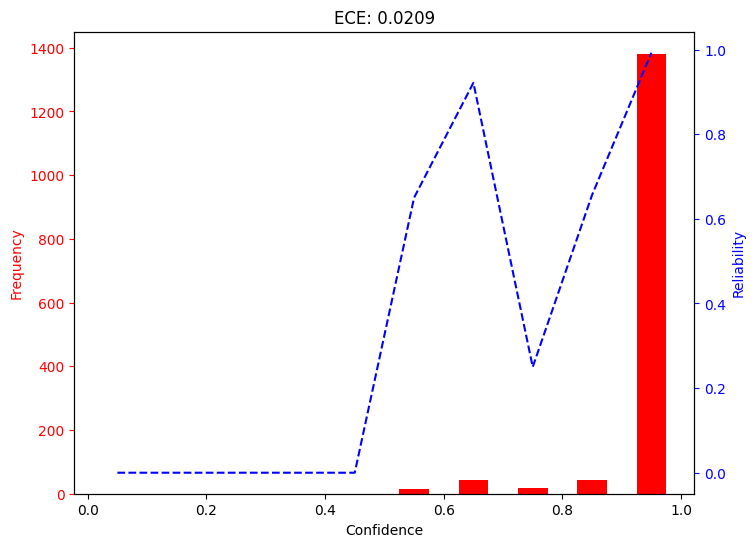

ECE plot for pruning rate:  0.4


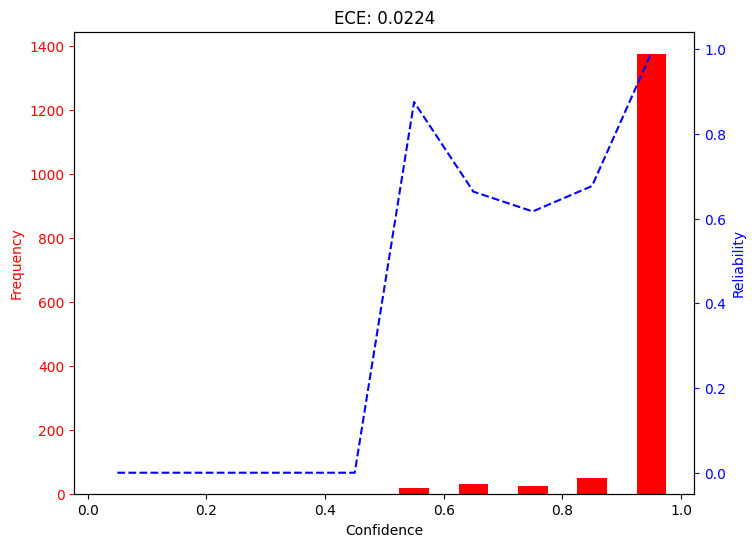

ECE plot for pruning rate:  0.5


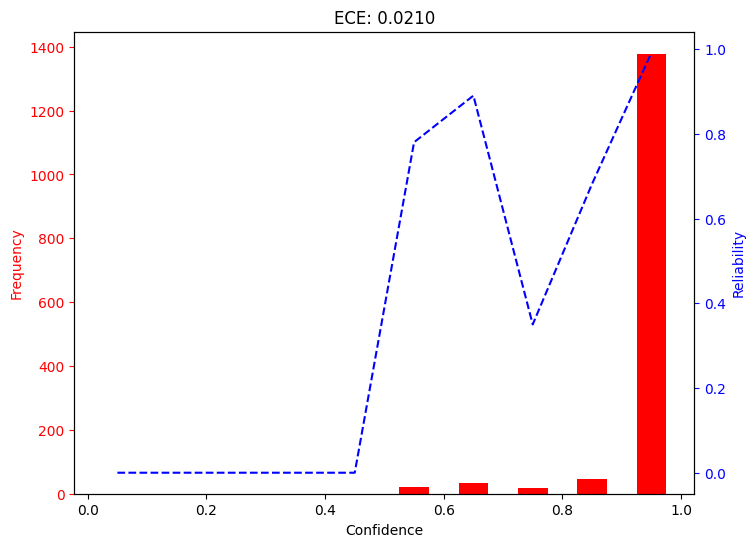

ECE plot for pruning rate:  0.6000000000000001


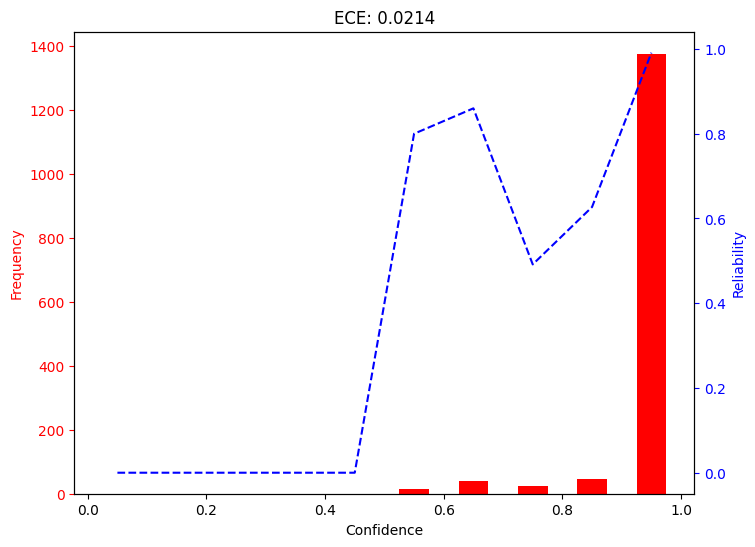

ECE plot for pruning rate:  0.7000000000000001


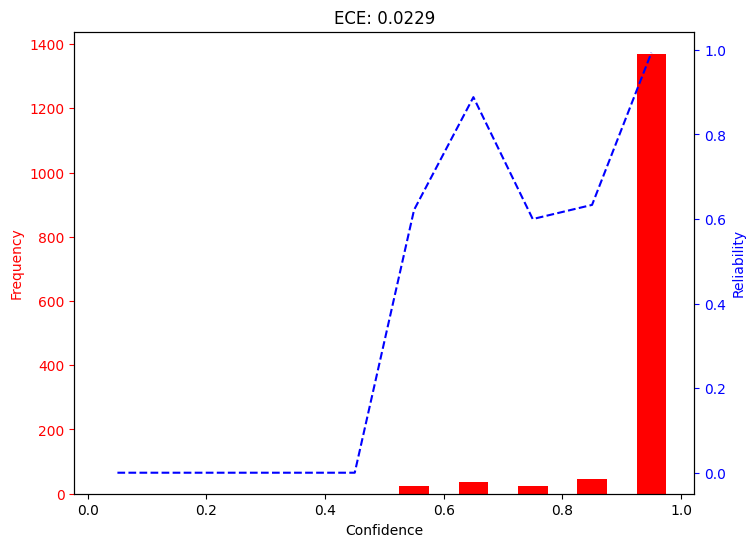

ECE plot for pruning rate:  0.8


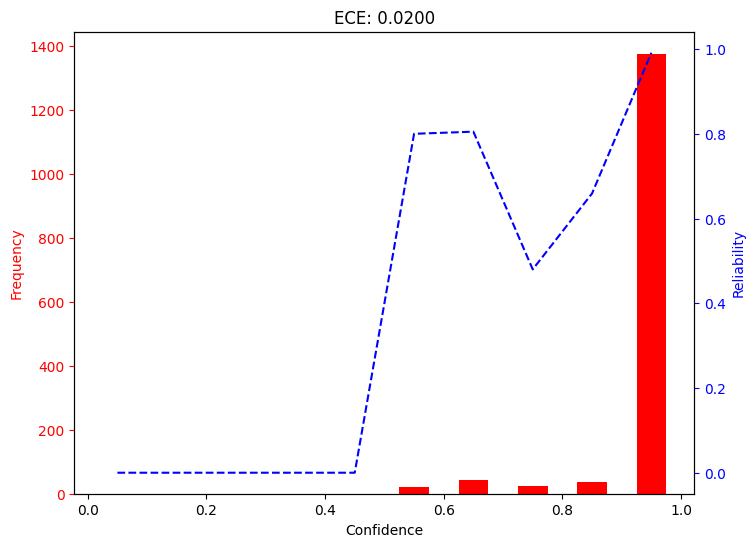

ECE plot for pruning rate:  0.9


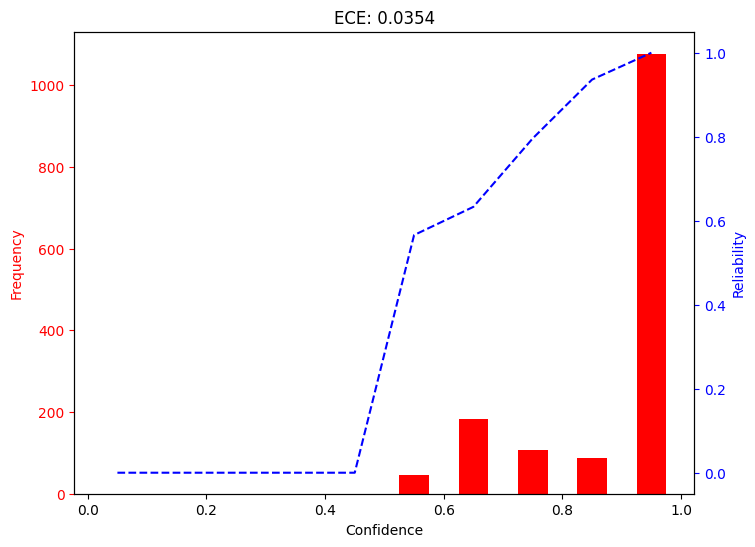

In [8]:
number_of_iterations = 10
pruning_rate = np.linspace(0,0.9, 10)
epochs = np.zeros((len(pruning_rate), number_of_iterations))
test_accuracies = np.zeros((len(pruning_rate), number_of_iterations))
ece = np.zeros((len(pruning_rate), number_of_iterations))
frequency = [ [] for _ in range(len(pruning_rate)) ]
reliabilities = [ [] for _ in range(len(pruning_rate)) ]

# Including multiple runs with separate initializations and random seeds.
for i in range(number_of_iterations):
    randomseed =  np.random.randint(0, 100)
    torch.manual_seed(randomseed)
    
    # Train the model with early stopping
    input_size = 2
    hidden_size = 30
    output_size = 2
    mlp_model = MLP(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)
    train_mlp_early_stopping(mlp_model, criterion, optimizer, torch.FloatTensor(X_train), torch.LongTensor(y_train),
                         torch.FloatTensor(X_val), torch.LongTensor(y_val))
    for p in range(len(pruning_rate)):
        model = copy.deepcopy(mlp_model)
        unpruned_layers = oneshot_pruning(model, input_size, output_size, pruning_rate[p])
        model.update_layers(unpruned_layers)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        epochs[p, i] = train_mlp_early_stopping(model, criterion, optimizer, torch.FloatTensor(X_train), torch.LongTensor(y_train),
                                torch.FloatTensor(X_val), torch.LongTensor(y_val))
        test_accuracies[p, i] = test_model(model, X_test, y_test)
        ece[p][i], freq, reliab = calculate_ece(model, X_test, y_test, title = 'testing')
        frequency[p].append(freq)
        reliabilities[p].append(reliab)
ece = np.mean(ece, axis=1)
frequency = np.sum(frequency, axis=1)
reliabilities = np.sum(reliabilities, axis=1)
for p in range(len(pruning_rate)):    
# Taking the average of the runs for each pruning rate
    print("ECE plot for pruning rate: ", pruning_rate[p])
    ece_plot(frequency[p], reliabilities[p]/10, ece[p], num_bins=10)


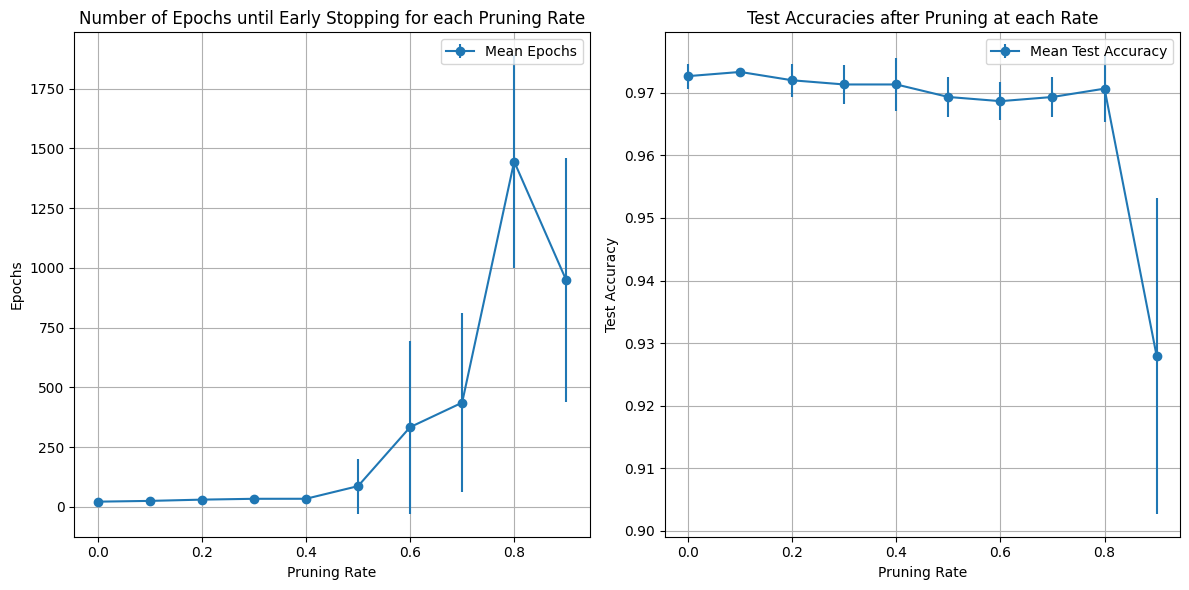

In [9]:
# Plot the performance on train and validation datasets
plt.figure(figsize=(12, 6))

# Plot the number of epochs until early stopping for each pruning rate with error bars
plt.subplot(1, 2, 1)
epochs_mean = epochs.mean(axis=1)
epochs_std = epochs.std(axis=1)
plt.errorbar(pruning_rate, epochs_mean, yerr=epochs_std, marker='o', label='Mean Epochs')
plt.title('Number of Epochs until Early Stopping for each Pruning Rate')
plt.xlabel('Pruning Rate')
plt.ylabel('Epochs')
plt.legend()
plt.grid(True)

# Plot the test accuracies after pruning at each rate with error bars
plt.subplot(1, 2, 2)
test_accuracies_mean = test_accuracies.mean(axis=1)
test_accuracies_std = test_accuracies.std(axis=1)
plt.errorbar(pruning_rate, test_accuracies_mean, yerr=test_accuracies_std, marker='o', label='Mean Test Accuracy')
plt.title('Test Accuracies after Pruning at each Rate')
plt.xlabel('Pruning Rate')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()